Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**INSTALL PRE-REQS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall
!pip install -U scikit-image==0.16.2
!pip install imageio
!pip install openslide-python

In [ ]:
!pip install -U keras==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**IMPORT LIBRARIES**

In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Mask_RCNN')
!ls

assets	LICENSE      MaskRCNN_cell  README.md	      samples	 setup.py
images	MANIFEST.in  mrcnn	    requirements.txt  setup.cfg  test12.png


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import sys
from tensorflow.python.keras import backend as K
from PIL import Image
import json
import numpy as np
import pandas as pd
import time
import skimage
import matplotlib.pyplot as plt
import imageio
from PIL import Image, ImageDraw


In [ ]:
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa
# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

**ROOT DIRECTORY INITIALIZATION**

In [ ]:
# Make a directory to save trained weights
ROOT_DIR = "/content/drive/MyDrive/"
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# path to COCO-dataset weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

**TRAIN DATA LOADING**

In [ ]:
data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/images/')):
    data.append(file)

# Create a dataframe out of files in the respective directory
df_train_data = pd.DataFrame(data, columns=['imageid'])
df_train_data['imageid'] = df_train_data['imageid'].str.replace('.jpg','')

# make a list out of `image_id` column from the dataframe.
train_data_imageid = df_train_data['imageid'].tolist()

print('Number of training images: ', len(train_data_imageid))


data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/val_images/')):
    data.append(file)

df_validation_data = pd.DataFrame(data, columns=['imageid'])
df_validation_data['imageid'] = df_validation_data['imageid'].str.replace('.jpg','')

validation_data_imageid = df_validation_data['imageid'].tolist()

print('Number of validation images: ', len(validation_data_imageid))


data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/masks/')):
    data.append(file)

df_train_mask = pd.DataFrame(data, columns=['imageid'])
df_train_mask['imageid'] = df_train_mask['imageid'].str.replace('.jpg','')

train_mask_imageid = df_train_mask['imageid'].tolist()

print('Number of training masks: ', len(train_mask_imageid))
#for i in range(len(train_mask_imageid)):
  #print(train_mask_imageid[i])


data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/val_masks/')):
    data.append(file)

df_validation_mask = pd.DataFrame(data, columns=['imageid'])
df_validation_mask['imageid'] = df_validation_mask['imageid'].str.replace('.jpg','')

validation_mask_imageid = df_validation_mask['imageid'].tolist()

print('Number of validation masks: ', len(validation_mask_imageid))




Number of training images:  652
Number of validation images:  12
Number of training masks:  652
Number of validation masks:  12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: The default value of regex will change from True to False in a future version.


**MODEL CLASS CONFIGURATION**

In [ ]:
class NucleusConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "nucleus"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 6

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (675 - len(validation_data_imageid)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(validation_data_imageid) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
#     MEAN_PIXEL = np.array([43.53, 39.56, 48.22])
    MEAN_PIXEL = np.array([47.49, 41.63, 51.28])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200
#     MAX_GT_INSTANCES = 2000
    #LEARNING_RATE = 0.000001
    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400
#     DETECTION_MAX_INSTANCES = 2000
    
config = NucleusConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

**DATASET LOADING**

In [ ]:
class NucleusDataset(utils.Dataset):

    def load_data(self, image_ids):
   
        self.add_class('nucleus', 1, 'Nucleus')
        #self.add_class("nucleus", 2, "2")
        #self.add_class("nucleus", 3, "3")
        #self.add_class("nucleus", 4, "4")
       # self.add_class("nucleus", 5, "fibroblast")
       # self.add_class("nucleus", 6, "muscle")
       # self.add_class("nucleus", 7, "endothelial")
       
        # Add the image using the base method from utils.Dataset
        if(image_ids == train_data_imageid):
          for image in image_ids:
              self.add_image('nucleus', 
                            image_id=image, 
                            path=('/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/images/' + image), 
                            labels=1)
              #print(image)
        if(image_ids == validation_data_imageid):
           for image in image_ids:
              self.add_image('nucleus', 
                            image_id=image, 
                            path=('/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/val_images/' + image  ), 
                            labels=1) 
              
    def load_mask(self, image_id):
  
        info = self.image_info[image_id]
        image_id = info['id']
        data = []
        for file in sorted(os.listdir(r'/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/masks/')):
            data.append(file)
            #print(file)
        matching = [s for s in data if image_id in s]
        
        result = [] 
        
        for match in matching:
            im = Image.open('/content/drive/MyDrive/Train_Dataset_ACV_Project_CPM17/masks//{}'.format(match))
            im = np.asarray(im)
            im = im.reshape((im.shape[0], im.shape[1], 1))
            result.append(im)
            
        # n (512, 512) arrays -> (512, 512, n)
        im = np.dstack(result)
        
        # class_ids should be a numpy array not python list.
        class_ids = np.array([1 for _ in range(im.shape[-1])])
        return im, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nucleus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

**TRAINING AND INFERENCE FUNCTIONS**

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = NucleusDataset()
    dataset_train.load_data(train_data_imageid)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = NucleusDataset()
    dataset_val.load_data(validation_data_imageid)
    dataset_val.prepare()

    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

    # *** This training schedule is an example. Update to your needs ***

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
#     print("Train network heads")
#     model.train(dataset_train, dataset_val,
#                 learning_rate=config.LEARNING_RATE,
#                 epochs=20,
#                 augmentation=augmentation,
#                 layers='heads')
    
    print("Train all layers")
    x_epoch, y_tra_loss, y_val_loss = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=50,
                augmentation=augmentation,
                layers='all')
    return x_epoch, y_tra_loss, y_val_loss 

**TRAIN LOSS AND VALIDATION LOSS PLOT FUNCTION**

In [ ]:
def loss_visualize(epoch, tra_loss, val_loss):
    plt.style.use("ggplot")
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.title("Epoch_Loss")
    plt.plot(epoch, tra_loss, label='train_loss', color='r', linestyle='-', marker='o')
    plt.plot(epoch, val_loss, label='val_loss', linestyle='-', color='b', marker='^')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
   # plt.savefig(os.path.join(RESULT_DIR, 'loss.jpg'))
    plt.show()

In [ ]:
def rle_encode(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it column wise
    m = mask.T.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    return " ".join(map(str, rle.flatten()))


def rle_decode(rle, shape):
    """Decodes an RLE encoded list of space separated
    numbers and returns a binary mask."""
    rle = list(map(int, rle.split()))
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask


def mask_to_rle(image_id, mask, scores):
    "Encodes instance masks to submission format."
    assert mask.ndim == 3, "Mask must be [H, W, count]"
    # If mask is empty, return line with image ID only
    if mask.shape[-1] == 0:
        return "{},".format(image_id)
    # Remove mask overlaps
    # Multiply each instance mask by its score order
    # then take the maximum across the last dimension
    order = np.argsort(scores)[::-1] + 1  # 1-based descending
    mask = np.max(mask * np.reshape(order, [1, 1, -1]), -1)
    # Loop over instance masks
    lines = []
    for o in order:
        m = np.where(mask == o, 1, 0)
        # Skip if empty
        if m.sum() == 0.0:
            continue
        rle = rle_encode(m)
        lines.append("{}, {}".format(image_id, rle))
    return "\n".join(lines)


############################################################
#  Detection
############################################################

def detect(model, dataset_dir):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))


    # Read dataset
    dataset = NucleusDataset()
    dataset.load_data(dataset_dir)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        #plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

    # Save to csv file
    #submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    #file_path = os.path.join(submit_dir, "submit.csv")
    #with open(file_path, "w") as f:
     #   f.write(submission)
    #print("Saved to ", submit_dir)


**MODEL INITIALIZATION**

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
epoch, loss, val_loss = train(model)

Train all layers

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/logs/nucleus20220612T1033/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
109/110 [============================>.] - ETA: 1s - loss: 3.1230 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 2.3313 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.4653

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



110/110 [==============================] - 308s 3s/step - loss: 3.1040 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 2.3141 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1957 - mrcnn_mask_loss: 0.4654 - val_loss: 1.0026 - val_rpn_class_loss: 0.0148 - val_rpn_bbox_loss: 0.3927 - val_mrcnn_class_loss: 0.0296 - val_mrcnn_bbox_loss: 0.0419 - val_mrcnn_mask_loss: 0.5235
Epoch 2/30
110/110 [==============================] - 147s 1s/step - loss: 0.8368 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2337 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.5075 - val_loss: 0.6644 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.1055 - val_mrcnn_class_loss: 0.0154 - val_mrcnn_bbox_loss: 0.0144 - val_mrcnn_mask_loss: 0.5227
Epoch 3/30
110/110 [==============================] - 151s 1s/step - loss: 0.7114 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.4987 - val_loss: 0.6599 - val_rpn_class_loss: 0.013

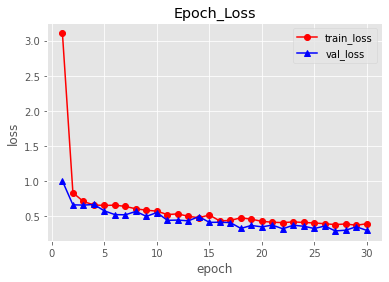

In [ ]:
loss_visualize(epoch, loss, val_loss)

In [ ]:
epoch, loss, val_loss = train(model)

Train all layers

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/logs/nucleus20220611T1422/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 1/50
109/110 [============================>.] - ETA: 2s - loss: 0.3102 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.2202

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


110/110 [==============================] - 474s 4s/step - loss: 0.3102 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.2204 - val_loss: 0.2663 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.0161 - val_mrcnn_class_loss: 1.9981e-04 - val_mrcnn_bbox_loss: 0.0021 - val_mrcnn_mask_loss: 0.2466
Epoch 2/50
110/110 [==============================] - 152s 1s/step - loss: 0.3454 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.2258 - val_loss: 0.3099 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.0820 - val_mrcnn_class_loss: 0.0038 - val_mrcnn_bbox_loss: 0.0066 - val_mrcnn_mask_loss: 0.2161
Epoch 3/50
110/110 [==============================] - 151s 1s/step - loss: 0.3335 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.2230 - val_loss: 0.2460 - val_rpn_class_loss: 7.

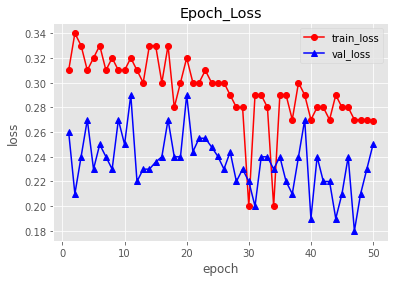

In [ ]:
loss_visualize(epoch, loss, val_loss)

**SAVE WEIGHTS**

In [ ]:
model_path = os.path.join("/content/drive/MyDrive/", "mask_rcnn_nucleus_cpm17_2.h5")
model.keras_model.save_weights(model_path)

**INFERENCE CLASS CONFIGURATION**

In [ ]:
class NucleusInferenceConfig(NucleusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

**LOAD SAVED WEIGHTS**

In [ ]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import tensorflow as tf
config = NucleusInferenceConfig()
config.display()
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
with tf.device(DEVICE):
    nmodel1 = modellib.MaskRCNN(mode="inference",
                              model_dir=MODEL_DIR,
                              config=config)

weights_path = "/content/drive/MyDrive/mask_rcnn_nucleus_cpm17_2.h5"
#nmodel1.load_weights(model.find_last()[1], by_name=True)
nmodel1.load_weights(weights_path, by_name=True)  


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

**TEST DATA FOR BASELINE MODEL**

In [ ]:

data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/cpm17/test/Images')):
    data.append(file)

test_imgs = pd.DataFrame(data, columns=['imageid'])
test_imgs['imageid'] = test_imgs['imageid'].str.replace('.jpg','')

test_imageid = test_imgs['imageid'].tolist()

print('Number of training masks: ', len(test_imageid))
#for i in range(len(train_mask_imageid)):
  #print(train_mask_imageid[i])


data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/cpm17/test/pnglabels')):
    data.append(file)

test_mask = pd.DataFrame(data, columns=['imageid'])
test_mask['imageid'] = test_mask['imageid'].str.replace('.jpg','')

test_mask_imageid = test_mask['imageid'].tolist()

print('Number of validation masks: ', len(test_mask_imageid))

data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/cpm17/test/Overlay')):
    data.append(file)

test_overlay_mask = pd.DataFrame(data, columns=['imageid'])
test_overlay_mask['imageid'] = test_overlay_mask['imageid'].str.replace('.jpg','')

test_overlay_imageid = test_overlay_mask['imageid'].tolist()

print('Number of overlayed masks: ', len(test_overlay_imageid))

Number of training masks:  31
Number of validation masks:  31
Number of overlayed masks:  31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
test_overlay_imageid = np.array(test_overlay_imageid)

In [ ]:
test_overlay_imageid.shape

(32,)

In [ ]:

import random
randomlist = random.sample(range(0, 772), 200)
prediction1 = []
gt1 = []
length = 100
for i in range(31):
  #i = randomlist[j]
  image_name = "/content/drive/MyDrive/cpm17/test/Images/" + str(test_imageid[i])
  print(image_name)
  im = imageio.imread(image_name)
  im  = cv2.resize(im, (500, 500))
  r = nmodel1.detect([im], verbose=1)[0]
  plt.figure(figsize=(20,5),dpi=100)
  ax1=plt.subplot(1,5,1)
  plt.imshow(im)
  plt.title('Input Image')
  plt.axis('off')
  ax2=plt.subplot(1,5,2)
  visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'],['BG','-'], r['scores'],show_bbox=False, ax=ax2)
  plt.title('Prediction overlap with input')
  plt.axis('off')
  plt.subplot(1,5,3)
  individual_nuclei = r['masks']
  patch_size = 500
  predicted_nuclei = np.zeros((patch_size,patch_size), dtype = int)
  n_nuc = 0
  for k in range(individual_nuclei.shape[2]):
      n_nuc += 1
      nuc_mask = r['masks'][:,:,k]
      predicted_nuclei += (n_nuc)*nuc_mask
  predicted_nuclei = predicted_nuclei >0
  prediction1.append(predicted_nuclei)
  plt.imshow(predicted_nuclei)
  plt.title('Output Mask')
  plt.axis('off')
  plt.subplot(1,5,4)
  gt_overlapped = "/content/drive/MyDrive/cpm17/test/Overlay/" + str(test_overlay_imageid[i])
  overlay = imageio.imread(gt_overlapped)
  overlay = cv2.resize(overlay, (500, 500)) 
  #ax3=plt.subplot(1,5,2)
  #color = (1.0, 0.0, 0.0)
  #overlay = visualize.apply_mask(im,overlay, color)
  plt.imshow(overlay)
  plt.title('Original Mask Overlay')
  plt.axis('off')
  plt.subplot(1,5,5)
  mask  = "/content/drive/MyDrive/cpm17/test/pnglabels/" + str(test_mask_imageid[i])
  msk = imageio.imread(mask)
  
  msk = cv2.resize(msk, (500, 500)) 
  msk = msk>0
  gt1.append(msk)
  plt.imshow(msk)
  plt.title('Groundtruth')
  plt.axis('off')
  plt.show()  
  print(i)

**AJI SCORE BASELINE MODEL**

In [ ]:
get_fast_aji(gt1, prediction1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


0.17649937540138252

**DQ /SQ/ PQ SCORE BASELINE MODEL**

In [ ]:

gt2 = np.array(gt1)
prediction2 = np.array(prediction1)

In [ ]:

get_fast_pq(gt1, prediction1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:220: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:227: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


matched
average of DQ 0.2624372442652709


[0.2624372442652709, 0.17649937540138252, 0.046320009694880364]

**DICE SCORE BASELINE MODEL**

In [ ]:

get_dice_1(gt1, prediction1)

0.3000415964371707

**TEST DATA FOR ENHANCED MODEL**

In [ ]:

data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/cpm17/test/prepped_test_data/images')):
    data.append(file)

test_imgs = pd.DataFrame(data, columns=['imageid'])
test_imgs['imageid'] = test_imgs['imageid'].str.replace('.jpg','')

test_imageid = test_imgs['imageid'].tolist()

print('Number of training masks: ', len(test_imageid))
#for i in range(len(train_mask_imageid)):
  #print(train_mask_imageid[i])


data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/cpm17/test/prepped_test_data/masks')):
    data.append(file)

test_mask = pd.DataFrame(data, columns=['imageid'])
test_mask['imageid'] = test_mask['imageid'].str.replace('.jpg','')

test_mask_imageid = test_mask['imageid'].tolist()

print('Number of validation masks: ', len(test_mask_imageid))

data = []
for file in sorted(os.listdir(r'/content/drive/MyDrive/cpm17/test/overlays')):
    data.append(file)

test_overlay_mask = pd.DataFrame(data, columns=['imageid'])
test_overlay_mask['imageid'] = test_overlay_mask['imageid'].str.replace('.jpg','')

test_overlay_imageid = test_overlay_mask['imageid'].tolist()

print('Number of overlayed masks: ', len(test_overlay_imageid))

Number of training masks:  772
Number of validation masks:  772
Number of overlayed masks:  772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
prediction = []
gt = []
import random
randomlist = random.sample(range(0, 772), 200)
prediction = []
gt = []
length = 100
for j in range(100):
  i = randomlist[j]
  image_name = "/content/drive/MyDrive/cpm17/test/prepped_test_data/images/" + str(test_imageid[i])
  im = imageio.imread(image_name)
  r = nmodel1.detect([im], verbose=1)[0]
  plt.figure(figsize=(20,5),dpi=100)
  ax1=plt.subplot(1,5,1)
  plt.imshow(im)
  plt.title('Input Image')
  plt.axis('off')
  ax2=plt.subplot(1,5,2)
  visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'], r['scores'], ax=ax2)
  plt.title('Prediction overlap with input')
  plt.axis('off')
  plt.subplot(1,5,3)
  individual_nuclei = r['masks']
  patch_size = 256
  predicted_nuclei = np.zeros((patch_size,patch_size), dtype = int)
  n_nuc = 0
  for k in range(individual_nuclei.shape[2]):
      n_nuc += 1
      nuc_mask = r['masks'][:,:,k]
      predicted_nuclei += (n_nuc)*nuc_mask
  predicted_nuclei = predicted_nuclei >0
  prediction.append(predicted_nuclei)
  plt.imshow(predicted_nuclei)
  plt.title('Output Mask')
  plt.axis('off')
  plt.subplot(1,5,4)
  gt_overlapped = "/content/drive/MyDrive/cpm17/test/overlays/" + str(test_overlay_imageid[i])
  overlay = imageio.imread(gt_overlapped)
   
  #ax3=plt.subplot(1,5,2)
  #color = (1.0, 0.0, 0.0)
  #overlay = visualize.apply_mask(im,overlay, color)
  plt.imshow(overlay)
  plt.title('Original Mask Overlay')
  plt.axis('off')
  plt.subplot(1,5,5)
  mask  = "/content/drive/MyDrive/cpm17/test/mask/" + str(test_mask_imageid[i])
  msk = imageio.imread(mask)
  msk = msk>0
  gt.append(msk)
  plt.imshow(msk)
  plt.title('Groundtruth')
  plt.axis('off')
  plt.show()  
  print(i)

**AJI SCORE ENHANCED MODEL**

In [ ]:
get_fast_aji(gt, prediction)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


0.6657549820105473

**DQ/ SQ/ PQ SCORE ENHANCED MODEL**

In [ ]:

get_fast_pq(gt, prediction)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:220: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:227: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


matched
average of DQ 0.7972845782361972


[0.7972845782361972, 0.6657549820105473, 0.5307961800409263]

**DICE SCORE ENHANCED MODEL**

In [ ]:
get_dice_1( prediction,gt)

average of Dice Coefficient 0.8080224288228556


**Evaluation Metric functions**

In [ ]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import linear_sum_assignment

def DQ(testing_imgs,y_masks):
  dq = []
  for i in range(100):
    
    #ground_truth= y_masks[i]
    #test_pred1 = model.predict(test_img_input1)
    y_test = testing_imgs[i]
    test_mask=y_masks[i]
   
    dq.append(K.eval(f1(test_mask, y_test)))
  print ("average of DQ", sum(dq) / 100)
  return sum(dq)/100
def f1( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        v1 =  K.sum(y_true_f) / intersection
        v2 =  K.sum(y_pred_f)/ intersection
        return (2+ K.epsilon()) / (
                   v1 + v2 + K.epsilon())     
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score

epsilon = 1e-5
def dice_coef( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
def testMetrics(testing_imgs,y_masks):
  dice_coefficient_test = []
  for i in range(31):
    
    #ground_truth= y_masks[i]
    #test_pred1 = model.predict(test_img_input1)
    y_test = testing_imgs[i]
    test_mask=y_masks[i]
   
    dice_coefficient_test.append(K.eval(dice_coef(test_mask, y_test)))
  print ("average of Dice Coefficient", sum(dice_coefficient_test) / 31)        
#####
def get_fast_pq(true, pred, match_iou=0.3):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique 
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing. 
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.    
    
    Fast computation requires instance IDs are in contiguous orderding 
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand 
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]: 
                      pairing information to perform measurement
                    
    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.3:
        print("matched")
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    
    # get the F1-score i.e DQ
    dq1 = tp / (tp + 0.5 * fp + 0.5 * fn)
    gtx = true.astype("float64")
    predictionx = pred.astype("float64")
    dq = DQ(gtx, predictionx)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp)

    return [dq, sq, dq * sq]





#####--------------------------As pseudocode
def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    return 2.0 * np.sum(inter) / np.sum(denom)



def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3] 
    not [0, 2, 4, 6]. The ordering of instances (which one comes first) 
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred


#####
def pair_coordinates(setA, setB, radius):
    """Use the Munkres or Kuhn-Munkres algorithm to find the most optimal 
    unique pairing (largest possible match) when pairing points in set B 
    against points in set A, using distance as cost function.
    Args:
        setA, setB: np.array (float32) of size Nx2 contains the of XY coordinate
                    of N different points 
        radius: valid area around a point in setA to consider 
                a given coordinate in setB a candidate for match
    Return:
        pairing: pairing is an array of indices
        where point at index pairing[0] in set A paired with point
        in set B at index pairing[1]
        unparedA, unpairedB: remaining poitn in set A and set B unpaired
    """
    # * Euclidean distance as the cost matrix
    pair_distance = scipy.spatial.distance.cdist(setA, setB, metric='euclidean')

    # * Munkres pairing with scipy library
    # the algorithm return (row indices, matched column indices)
    # if there is multiple same cost in a row, index of first occurence 
    # is return, thus the unique pairing is ensured
    indicesA, paired_indicesB = linear_sum_assignment(pair_distance)

    # extract the paired cost and remove instances 
    # outside of designated radius
    pair_cost = pair_distance[indicesA, paired_indicesB]

    pairedA = indicesA[pair_cost <= radius]
    pairedB = paired_indicesB[pair_cost <= radius]

    pairing = np.concatenate([pairedA[:,None], pairedB[:,None]], axis=-1)
    unpairedA = np.delete(np.arange(setA.shape[0]), pairedA)
    unpairedB = np.delete(np.arange(setB.shape[0]), pairedB)
    return pairing, unpairedA, unpairedB